In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pathlib import Path
import torch
import random
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

In [4]:
from lib import common

In [5]:
pd.options.mode.chained_assignment = None

### Path

In [6]:
path = Path('/kaggle/osic_pulmonary')
assert path.exists()

### Read Data

In [7]:
train_df, test_df, submission_df = common.read_data(path)

#### Feature generation

In [8]:
len(train_df)

1542

In [9]:
submission_df['Patient'] = submission_df['Patient_Week'].apply(lambda x:x.split('_')[0])
submission_df['Weeks'] = submission_df['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
submission_df = submission_df[['Patient','Weeks','Confidence','Patient_Week']]
submission_df = submission_df.merge(test_df.drop('Weeks', axis=1).copy(), on=['Patient'])

In [10]:
test_df[test_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker


In [11]:
train_df[train_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1504,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker
1505,ID00419637202311204720264,7,2859,66.445107,73,Male,Ex-smoker
1506,ID00419637202311204720264,9,2783,64.678810,73,Male,Ex-smoker
1507,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker
1508,ID00419637202311204720264,13,2738,63.632984,73,Male,Ex-smoker
1509,ID00419637202311204720264,18,2694,62.610394,73,Male,Ex-smoker
1510,ID00419637202311204720264,31,2708,62.935764,73,Male,Ex-smoker
1511,ID00419637202311204720264,43,2793,64.911224,73,Male,Ex-smoker
1512,ID00419637202311204720264,59,2727,63.377335,73,Male,Ex-smoker


In [12]:
submission_df[submission_df['Patient'] == 'ID00419637202311204720264'].head(10)

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186852,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186852,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186852,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186852,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186852,73,Male,Ex-smoker
5,ID00419637202311204720264,-7,100,ID00419637202311204720264_-7,3020,70.186852,73,Male,Ex-smoker
6,ID00419637202311204720264,-6,100,ID00419637202311204720264_-6,3020,70.186852,73,Male,Ex-smoker
7,ID00419637202311204720264,-5,100,ID00419637202311204720264_-5,3020,70.186852,73,Male,Ex-smoker
8,ID00419637202311204720264,-4,100,ID00419637202311204720264_-4,3020,70.186852,73,Male,Ex-smoker
9,ID00419637202311204720264,-3,100,ID00419637202311204720264_-3,3020,70.186852,73,Male,Ex-smoker


Adding missing values

In [13]:
train_df['WHERE'] = 'train'
test_df['WHERE'] = 'val'
submission_df['WHERE'] = 'test'
data = train_df.append([test_df, submission_df])

In [14]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [15]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base[base['Patient'] == 'ID00419637202311204720264']

,Patient,min_FVC,nb
1504,ID00419637202311204720264,3020,1


In [16]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
data['base_week'] = data['base_week']
del base

In [17]:
data[data['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,nb,base_week
1498,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,0.0
1499,ID00419637202311204720264,7,2859,66.445107,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,1.0
1500,ID00419637202311204720264,9,2783,64.678810,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,3.0
1501,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,4.0
1502,ID00419637202311204720264,13,2738,63.632984,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,ID00419637202311204720264,129,3020,70.186852,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_129,6.0,3020,1,123.0
1689,ID00419637202311204720264,130,3020,70.186852,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_130,6.0,3020,1,124.0
1690,ID00419637202311204720264,131,3020,70.186852,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_131,6.0,3020,1,125.0
1691,ID00419637202311204720264,132,3020,70.186852,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_132,6.0,3020,1,126.0


In [18]:
cat_feats = ['SmokingStatus', 'Sex', 'Age']
label_encoders = {}
for cat_col in cat_feats:
    label_encoders[cat_col] = LabelEncoder()
    data[cat_col] = label_encoders[cat_col].fit_transform(data[cat_col])

In [19]:
def normalize(df:pd.DataFrame, cont_names):
    "Compute the means and stds of `self.cont_names` columns to normalize them."
    means, stds = {},{}
    for n in cont_names:
        means[n], stds[n] = df[n].mean(), df[n].std()
        df[n] = (df[n]-means[n]) / (1e-7 + stds[n])

In [20]:
data['BASE'] = data['min_FVC']
data['week'] = data['base_week']
data['percent'] = data['Percent']
normalize(data, ['BASE', 'week', 'percent'])

In [21]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,nb,base_week,BASE,week,percent
0,ID00007637202177411956430,-4,2315,58.253647,29,1,1,train,NaN,NaN,-4.0,2315,1,0.0,-0.636809,-0.876378,-1.142194
1,ID00007637202177411956430,5,2214,55.712128,29,1,1,train,NaN,NaN,-4.0,2315,1,9.0,-0.636809,-0.598597,-1.295784
2,ID00007637202177411956430,7,2061,51.862103,29,1,1,train,NaN,NaN,-4.0,2315,1,11.0,-0.636809,-0.536868,-1.528450
3,ID00007637202177411956430,9,2144,53.950680,29,1,1,train,NaN,NaN,-4.0,2315,1,13.0,-0.636809,-0.475140,-1.402233
4,ID00007637202177411956430,11,2069,52.063412,29,1,1,train,NaN,NaN,-4.0,2315,1,15.0,-0.636809,-0.413411,-1.516285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,ID00426637202313170790466,129,2925,71.824966,23,1,2,test,100.0,ID00426637202313170790466_129,0.0,2925,1,129.0,0.190043,3.105140,-0.322046
2273,ID00426637202313170790466,130,2925,71.824966,23,1,2,test,100.0,ID00426637202313170790466_130,0.0,2925,1,130.0,0.190043,3.136005,-0.322046
2274,ID00426637202313170790466,131,2925,71.824966,23,1,2,test,100.0,ID00426637202313170790466_131,0.0,2925,1,131.0,0.190043,3.166869,-0.322046
2275,ID00426637202313170790466,132,2925,71.824966,23,1,2,test,100.0,ID00426637202313170790466_132,0.0,2925,1,132.0,0.190043,3.197734,-0.322046


In [22]:
# data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
# data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
# data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
# data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE = ['SmokingStatus', 'Sex', 'Age','percent','week','BASE']

In [23]:
train_df = data.loc[data.WHERE=='train']
test_df = data.loc[data.WHERE=='val']
submission_df = data.loc[data.WHERE=='test']
del data

In [24]:
train_df['Sex'].unique()

array([1, 0])

In [25]:
train_df = train_df[FE + ['FVC']]
train_df

,SmokingStatus,Sex,Age,percent,week,BASE,FVC
0,1,1,29,-1.142194,-0.876378,-0.636809,2315
1,1,1,29,-1.295784,-0.598597,-0.636809,2214
2,1,1,29,-1.528450,-0.536868,-0.636809,2061
3,1,1,29,-1.402233,-0.475140,-0.636809,2144
4,1,1,29,-1.516285,-0.413411,-0.636809,2069
...,...,...,...,...,...,...,...
1537,2,1,23,-0.638128,-0.475140,0.190043,2712
1538,2,1,23,-0.243396,-0.289953,0.190043,2978
1539,2,1,23,-0.347273,0.080421,0.190043,2908
1540,2,1,23,-0.247849,0.450795,0.190043,2975


#### Seed

In [26]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
seed_everything(42)

### Create Dataset

In [27]:
class TabularDataset(Dataset):
    def __init__(self, data, cat_cols=None, output_col=None):
        self.n = len(data)
        if output_col:
            self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
        else:
            self.y = np.zeros((self.n, 1))
        self.cat_cols = cat_cols if cat_cols else []
        
        self.cont_cols = [
            col for col in data.columns if col not in self.cat_cols + [output_col]
        ]
        
        self.cont_X = data[self.cont_cols].astype(np.float32).values
        self.cat_X = data[cat_cols].astype(np.int64).values
        
    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n
    
    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]
    
    def __repr__(self):
        return f'cat_cols: {self.cat_cols} cont_cols: {self.cont_cols} cont_X: {self.cont_X.shape} cat_X: {self.cat_X.shape} y: {self.y.shape}'
    
    def cont_cols_len(self):
        return len(self.cont_cols)

In [28]:
# Test the dataset
sample_ds = TabularDataset(train_df, cat_cols=['SmokingStatus', 'Sex',  'Age'], output_col='FVC')

In [29]:
def create_dl(df, batch_size=128, num_workers=10):
    ds = TabularDataset(df, cat_cols=cat_feats, output_col='FVC')
    return DataLoader(ds, batch_size, shuffle=True, num_workers=num_workers)

In [30]:
sample_dl = create_dl(train_df)
y_sample, x_cont_sample, x_cat_sample = next(iter(sample_dl))
x_cont_sample.shape, x_cat_sample.shape, y_sample.shape

(torch.Size([128, 3]), torch.Size([128, 3]), torch.Size([128, 1]))

### Prepare neural network

In [31]:
cat_dims = [int(train_df[col].nunique()) for col in cat_feats]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
emb_dims

[(3, 2), (2, 1), (34, 17)]

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

def move_to_dev(*args):
    return [x.to(device) for x in args]

In [33]:
C1, C2 = torch.tensor(70, dtype=torch.float32), torch.tensor(1000, dtype=torch.float32)
C1, C2 = move_to_dev(C1, C2)
Q = torch.tensor([0.2, 0.50, 0.8]).float().to(device)

def score(y_true, y_pred):
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = torch.max(sigma, C1)
    delta = torch.abs(y_true[:, 0] - fvc_pred)
    delta = torch.min(delta, C2)
    sq2 = torch.sqrt(torch.tensor(2.))
    metric = (delta / sigma_clip)*sq2 + torch.log(sigma_clip* sq2)
    return torch.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    e = y_true - y_pred
    v = torch.max(Q*e, (Q-1)*e)
    return torch.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        y_true = y_true.unsqueeze(1)
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

In [34]:
class OsicModel(nn.Module):
    def __init__(self, emb_dims, no_of_cont, lin_layer_sizes, output_size=3, emb_dropout=0.0, lin_layer_dropouts=[0.001,0.001], y_range=[0, 5000]):
        super().__init__()
        
        # Embedding layers
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        self.no_of_embs = sum([y for _, y in emb_dims])
        self.no_of_cont = no_of_cont
        
        # Linear Layers
        first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont, lin_layer_sizes[0])
        self.lin_layers = nn.ModuleList(
            [first_lin_layer] + [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1]) for i in range(len(lin_layer_sizes) - 1)]
        )
        
        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)
            
        # Output Layers
        self.p1 = nn.Linear(lin_layer_sizes[-1], 3)
        self.p2 = nn.Linear(lin_layer_sizes[-1], 3)
        for output_layer in [self.p1, self.p2]:
            nn.init.kaiming_normal_(output_layer.weight.data)
            
        # Batch Norm Layers
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont, momentum=0.1)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size) for size in lin_layer_sizes])
        
        # Dropout Layers
        self.emb_dropout_layer = nn.Dropout(emb_dropout) if emb_dropout > 0.0 else None
        self.droput_layers = nn.ModuleList(
            [nn.Dropout(size) for size in lin_layer_dropouts]
        )
        
        self.y_range = y_range
        
    def forward(self, cont_data, cat_data):
        
        x = [emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
        x = torch.cat(x, 1)
        if self.emb_dropout_layer is not None:
            x = self.emb_dropout_layer(x)
        
        normalized_cont_data = self.first_bn_layer(cont_data)
        x = torch.cat([x, normalized_cont_data], 1)
        
        for i, (lin_layer, dropout_layer, bn_layer) in enumerate(zip(self.lin_layers, self.droput_layers, self.bn_layers)):
            x = F.relu(lin_layer(x))
            x = bn_layer(x)
#             x = dropout_layer(x)

        p1 = self.p1(x)
        p2 = F.relu(self.p2(x))
        preds = p1 + torch.cumsum(p2, axis=1)
        if self.y_range is not None:
            preds = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(preds) + self.y_range[0]
        return preds

In [35]:
def create_model(nh1=100, nh2=100):
    model = OsicModel(emb_dims, x_cont_sample.shape[1], [nh1, nh2])
    model = model.to(device)
    return model

In [36]:
sample_model = create_model(nh1=100, nh2=100)
sample_model

OsicModel(
  (emb_layers): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(34, 17)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=23, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (p1): Linear(in_features=100, out_features=3, bias=True)
  (p2): Linear(in_features=100, out_features=3, bias=True)
  (first_bn_layer): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (droput_layers): ModuleList(
    (0): Dropout(p=0.001, inplace=False)
    (1): Dropout(p=0.001, inplace=False)
  )
)

In [37]:
criterion=mloss(0.8)

In [38]:
y_sample, x_cont_sample, x_cat_sample = move_to_dev(y_sample, x_cont_sample, x_cat_sample)
y_sample.shape, x_cont_sample.shape, x_cat_sample.shape

(torch.Size([128, 1]), torch.Size([128, 3]), torch.Size([128, 3]))

In [39]:
# Test model

output = sample_model(x_cont_sample, x_cat_sample)
criterion(y_sample, output)

tensor(519.7242, grad_fn=<AddBackward0>)

#### Training functions

In [40]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [41]:
def eval_loop(valid_dl, model):
    model.eval()
    total_eval_loss = 0
    total_eval_score = 0
    for i, (y, x_cont, x_cat) in enumerate(valid_dl):
        y, x_cont, x_cat = move_to_dev(y, x_cont, x_cat)
        output = model(x_cont, x_cat)
        loss = criterion(y, output)
        total_eval_loss += loss.item()
        total_eval_score += score(y.unsqueeze(1), output)
        
    avg_val_loss = total_eval_loss / len(valid_dl)
    avg_val_score = total_eval_score / len(valid_dl) * -1
    return {
        'avg_val_loss': avg_val_loss,
        'avg_val_score': avg_val_score
    }

In [42]:
def train_loop(epochs, train_dl, valid_dl, model, lr = 1e-3):
    steps = len(train_dl) * epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)
    avg_train_losses = []
    avg_val_losses = []
    avg_val_scores = []
    lr = []
    for epoch in tqdm(range(epochs), total=epochs):
        model.train()
        total_train_loss = 0.0
        for i, (y, x_cont, x_cat) in enumerate(train_dl):
            y, x_cont, x_cat = move_to_dev(y, x_cont, x_cat)
            model.zero_grad()
            output = model(x_cont, x_cat)
            loss = criterion(y, output)
            total_train_loss += loss.item()
            
            # Backward Pass and Optimization
            loss.backward()
            optimizer.step()
            scheduler.step()
            lr.append(get_lr(optimizer))
        
        avg_train_loss = total_train_loss / len(train_dl)
        avg_train_losses.append(avg_train_loss)
        eval_res = eval_loop(valid_dl, model)
        avg_val_loss = eval_res['avg_val_loss']
        avg_val_score = eval_res['avg_val_score']
        avg_val_losses.append(avg_val_loss)
        avg_val_scores.append(avg_val_score.item())
#         print(f'{epoch}: avg_val_score: {avg_val_score}')
    return pd.DataFrame({'avg_train_losses': avg_train_losses, 'avg_val_losses': avg_val_losses, 'avg_val_scores': avg_val_scores}), pd.DataFrame({'lr': lr})

In [43]:
res_df, lr_df = train_loop(500, sample_dl, sample_dl, sample_model, lr=1e-3)

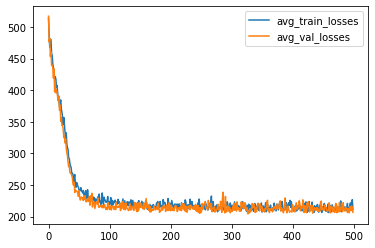

In [44]:
res_df[['avg_train_losses', 'avg_val_losses']].plot()

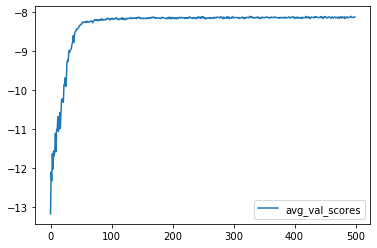

In [45]:
res_df[['avg_val_scores']].plot()

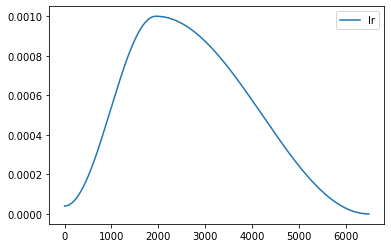

In [46]:
lr_df.plot()

In [47]:
res_df[['avg_val_scores']].max()

avg_val_scores   -8.102057
dtype: float64

#### Training

In [48]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)
EPOCHS=500

In [49]:
def convert_to_tensor(df, dtype):
    return torch.tensor(df.values, dtype=dtype).to(device)

In [50]:
cont_cols = sample_ds.cont_cols

In [51]:
cat_values = convert_to_tensor(submission_df[cat_feats], torch.int64)
cont_values = convert_to_tensor(submission_df[cont_cols], torch.float32)
cat_values.shape, cont_values.shape, cat_values.dtype

(torch.Size([730, 3]), torch.Size([730, 3]), torch.int64)

In [52]:
pe = np.zeros((cat_values.shape[0], 3))
pred = np.zeros((train_df.shape[0], 3))
pred.shape

(1542, 3)

In [53]:
def predict(cont_values, cat_values, model):
    return model(cont_values, cat_values).detach().cpu().numpy()

In [54]:
%%time

res_dfs = []
for cnt, (tr_idx, val_idx) in tqdm(enumerate(kf.split(train_df)), total=NFOLD):
    X_y_train = train_df.loc[tr_idx]
    X_y_valid = train_df.loc[val_idx]
    print(f"FOLD {cnt}", X_y_train.shape, X_y_valid.shape)
    model = create_model()
    train_dl = create_dl(X_y_train)
    valid_dl = create_dl(X_y_valid)
    res_df, _ = train_loop(EPOCHS, train_dl, valid_dl, model)
    res_dfs.append(res_df)
    pe += predict(cont_values, cat_values, model)
    pred[val_idx] = predict(
        convert_to_tensor(X_y_valid[cont_cols], torch.float32), 
        convert_to_tensor(X_y_valid[cat_feats], torch.int64), 
        model
    )

FOLD 0 (1233, 7) (309, 7)



FOLD 1 (1233, 7) (309, 7)



FOLD 2 (1234, 7) (308, 7)



FOLD 3 (1234, 7) (308, 7)



FOLD 4 (1234, 7) (308, 7)




CPU times: user 1h 15min 41s, sys: 1h 7min 20s, total: 2h 23min 1s
Wall time: 15min 1s


In [55]:
pe = pe / NFOLD

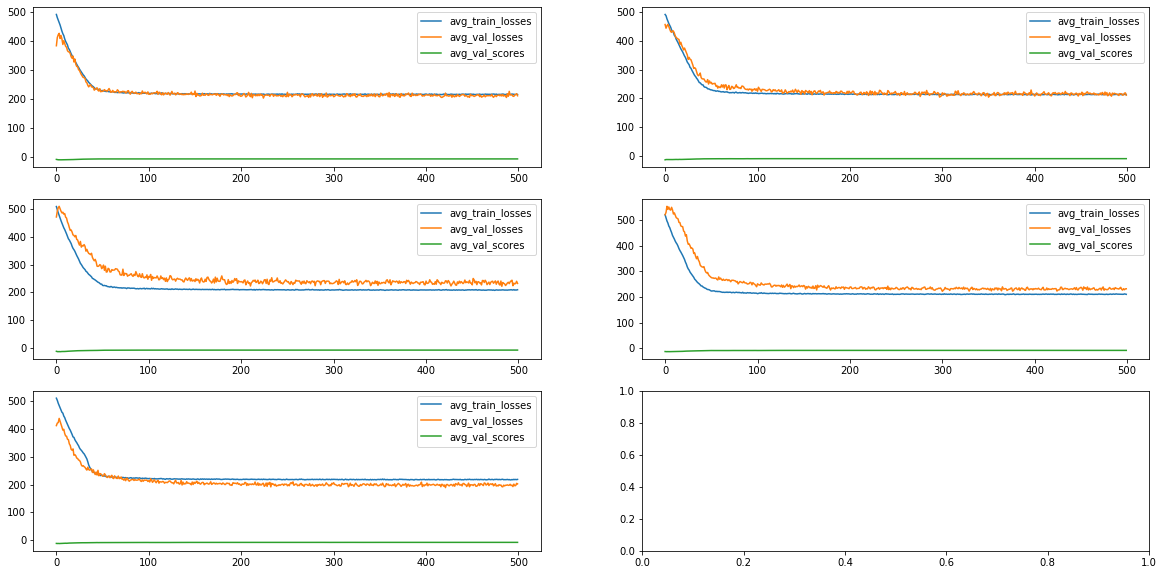

<Figure size 800x480 with 0 Axes>

In [56]:
from matplotlib.pyplot import figure

nrows = len(res_dfs) // 2 + 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
for r in range(nrows):
    for c in range(ncols):
        index = r * 2 + c
        if index < len(res_dfs):
            res_dfs[r * 2 + c].plot(ax=axes[r,c])

In [57]:
print("Mean validation score", np.mean([res_dfs[i]['avg_val_scores'][len(res_dfs[0]) - 1] for i in range(NFOLD)]))

Mean validation score -8.15509090423584


#### Prediction

In [59]:
sigma_opt = mean_absolute_error(train_df['FVC'], pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
sigma_opt, sigma_mean

(695.1763634193113, 1329.448906132838)

In [ ]:
submission_df['FVC1'] = pe[:,1]
submission_df['Confidence1'] = pe[:, 2] - pe[:, 0]

In [ ]:
submission_df.head(15)

In [ ]:
subm = submission_df[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [ ]:
subm.loc[~subm.FVC1.isnull()].shape, subm.shape

In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']

In [ ]:
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
subm.describe().T

In [ ]:
def replace_with_existing(df):
    for i in range(len(df)):
        patient_week_filter = subm['Patient_Week']==df.Patient[i]+'_'+str(df.Weeks[i])
        subm.loc[patient_week_filter, 'FVC'] = df.FVC[i]
        subm.loc[patient_week_filter, 'Confidence'] = 0.1

train_df = pd.read_csv(path/'train.csv', dtype = common.TRAIN_TYPES)
test_df = pd.read_csv(path/'test.csv', dtype = common.TRAIN_TYPES)
replace_with_existing(train_df)
replace_with_existing(test_df)

In [ ]:
subm[subm['Patient_Week'].str.find('ID00419637202311204720264') > -1].head(30)

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [ ]:
pd.read_csv('submission.csv')

In [ ]:
!cat submission.csv